<a href="https://colab.research.google.com/github/chocolateritillo/hello-world/blob/master/predict_fuel_efficiency%5Bregression%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.13.1
32768/30286 [================================] - 0s 1us/step
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
5    15.0          8         429.0       198.0  4341.0          10.0   
6    14.0          8         454.0       220.0  4354.0           9.0   
7    14.0          8         440.0       215.0  4312.0           8.5   
8    14.0          8         455.0       225.0  4425.0          10.0   
9    15.0          8         390.0       190.0  3850.0           8.5   
10   15.0          8         383.0       170.0  3563.0          10.0   
11   14.0          8         340.0       160.0  3609.0           8.0

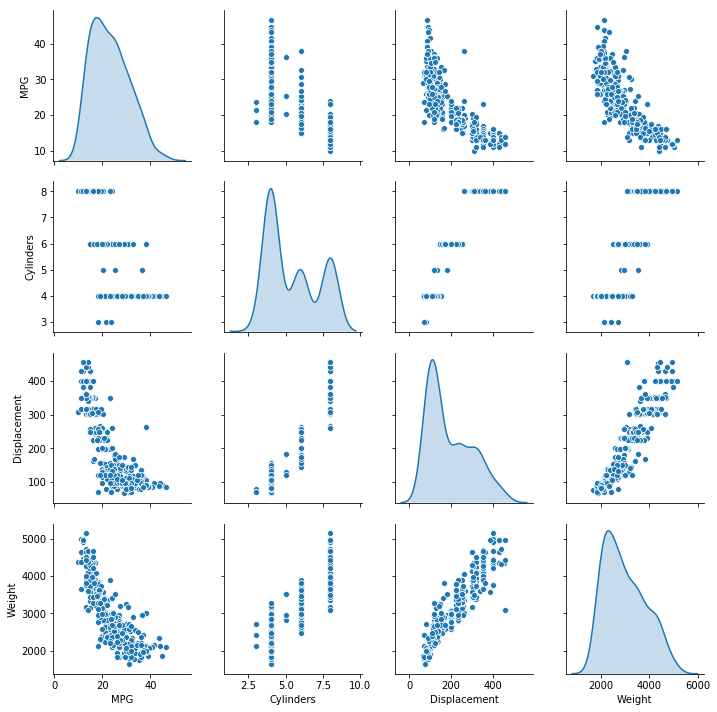

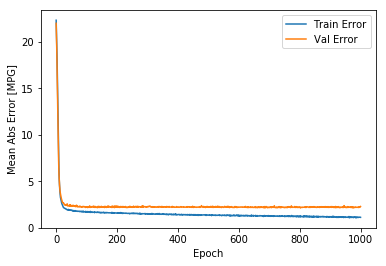

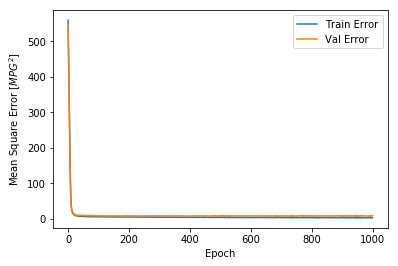

 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

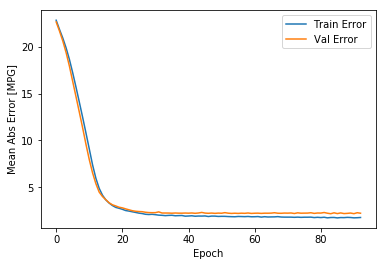

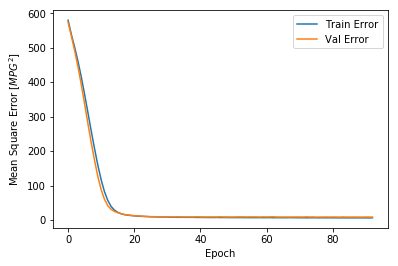

Testing set Mean Abs Error:  1.89 MPG


'END'

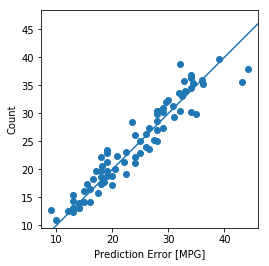

In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Link to original file: https://www.tensorflow.org/tutorials/keras/basic_regression

Created on Thu Mar 21 13:04:15 2019

@author: charmangel
"""

#Use seaborn for pairplot

from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

#import the data using pandas

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values= "?", comment= '\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

dataset.isna().sum()

dataset = dataset.dropna()

#the "origin" column is really categorical, not numeric. so convert that to a one-hot:

origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()
print(dataset)

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#inspect the data using seaborn:

sb.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#look at overall statistics:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)
#split features from labels. separate the target value, or 'label', from the features.
#this label is the value that you will train the model to predict.


train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#normalize the data. if i look again at the train_stats block above i can notice how different the ranges
#of the features are. it is good to practice to normalize features that use different scales and ranges.
#although the model might converge without feature normalization, it makes training more difficult, and 
#it makes the resulting model dependent on the choice of units used in the input

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#build the model
def build_model():
    model = keras.Sequential([
            layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
            layers.Dense(64, activation=tf.nn.relu),
            layers.Dense(1)
            ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                  optimizer = optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

model.summary()

#now try out the model. take a batch of 10 examples from the training data and call model.predict on it:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

#train the model

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print(' ')
        print('.', end=' ')

EPOCHS = 1000

#record the training and validation accuracy in the history object:
history = model.fit(
        normed_train_data, train_labels, 
        epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

#visualize the model's training progress using the stats stores in the history object:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

"""Hay un problema con esta función y es que me consiga
leer bien lo de plt.ylim en los dos casos... no veo nada en 
la gráfica al fin y al cabo si no la escalo."""

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

#let's update the model.fit call to automatically stop training when the validation score doesn't improve:
#we'll use an EarlyStopping callbback that tests a training condition for every epoch in such a way that if a set amount
#of epochs elapses without showing any improvement it will then automatically stop the training
#this callback (.keras.callbacks.EarlyStopping) is added to the callbacks parameter in the history object.

model = build_model()

#the patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

#now we use the test set:

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

#make predictions using the data in the testing set with the .predict statement:

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions) #introduzco el objeto test_predictions porque lo que me da return el model.predict ya sé
#que será un vector de estos que utiliza plt.scatter.
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100,100], [-100, 100])

#let's go see at the error distribution:

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

"""END"""